# Identifying the type of blood cells from images
![cover](https://drive.google.com/uc?export=view&id=1vCdFIYUiC_dY0vI7IvUtopXy6t-g9VFX)
The diagnosis of blood-based diseases often involves identifying and characterizing patient blood samples.  
So, providing automated methods to detect and classify blood cell subtypes would be a huge benefit and would have important medical applications.

# Data Exploration

This dataset contains 12,500 augmented images of blood cells (JPEG) with accompanying cell type labels (CSV). 

There are approximately 3,000 images for each of 4 different cell types grouped into 4 different folders (according to cell type).

This dataset is accompanied by an additional dataset containing the original 410 images (pre-augmentation) as well as two additional subtype labels (white blood cells WBC vs red blood cells RBC) and also bounding boxes for each cell in each of these 410 images (JPEG + XML metadata).

Types of blood cells are :
1. Mononuclear
  - Lymphocyte
  - Monocyte
  - Basophil
2. Polynuclear
  - Eosinophil
  - Neutrophil  


For more information about blood cells and blood cell subtypes, see the following links:
- https://www.ncbi.nlm.nih.gov/books/NBK2263/

- https://www.ncbi.nlm.nih.gov/books/NBK2263/box/A26/?report=objectonly


# Upload Local Data to Colab

In [33]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

ModuleNotFoundError: No module named 'google.colab'

# Setting up google drive data

In [0]:
!pip install -U -q PyDrive


In [18]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
def download_folder_content(folder_id):
  file_list = drive.ListFile(
      {'q': "'" + folder_id + "' in parents"}).GetList()

  for f in file_list:
    # 3. Create & download by id.
    print('title: %s, id: %s' % (f['title'], f['id']))
    fname = os.path.join(local_download_path, f['title'])
    if f['title'].find(".") != -1: # it's a file
      print('downloading to {}'.format(fname))
      f_ = drive.CreateFile({'id': f['id']})
      f_.GetContentFile(fname)
    else: # it's a folder
      print("\n Downloading Folder '{}'..".format(f['title']))
      download_folder_content(f['id'])

## main folder id: 1yDay-si1jzWg9iT6SbNy3nkk7_0_Xhz7
## images folder id: 1lq_CvZGmQ3PqZPrPSeOG-QVV-pHJCmCL
data_folder_id = "1lq_CvZGmQ3PqZPrPSeOG-QVV-pHJCmCL" 
download_folder_content(data_folder_id)


title: BloodImage_00407.jpg, id: 1a2zJmLaOpkX9UwL4WOPcresG8JL02o-m
downloading to /root/data/BloodImage_00407.jpg
title: BloodImage_00410.jpg, id: 1MLHg_vyprMljhFKymZdCQRwpcwz1PTCJ
downloading to /root/data/BloodImage_00410.jpg
title: BloodImage_00393.jpg, id: 10OlPkMt8FIPeMO48bC_rtSXty0uwAnat
downloading to /root/data/BloodImage_00393.jpg
title: BloodImage_00408.jpg, id: 15aq0m5XrmXsUfPVQzhQ2LvpbXXn2NTbU
downloading to /root/data/BloodImage_00408.jpg
title: BloodImage_00405.jpg, id: 12XxFFCe3hYw80uQjUKDB87x_dnkbr2C5
downloading to /root/data/BloodImage_00405.jpg
title: BloodImage_00409.jpg, id: 18mkLZsq4L0T9mngB2kQpL4iaH2RnPLkH
downloading to /root/data/BloodImage_00409.jpg
title: BloodImage_00395.jpg, id: 1p2I-qb_kRI-tkBWX9aLXjmC_X823fzjf
downloading to /root/data/BloodImage_00395.jpg
title: BloodImage_00396.jpg, id: 1IYgJZJN6ZF9hAq6MSZ2ZrV2ZCzZnb10h
downloading to /root/data/BloodImage_00396.jpg
title: BloodImage_00402.jpg, id: 1qPbGKRk4PgkEjYtveZCrICmLmOVU6aaj
downloading to /root/


# Getting Started

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import display # Allows the use of display() for DataFrames
import cv2
from keras.preprocessing import image
from sklearn.model_selection  import train_test_split

%matplotlib inline


Using TensorFlow backend.



# Data Preprocessing


## Read lables data

In [20]:
# read lables from a csv file
labels = pd.read_csv("../dataset/labels.csv")
labels.head(11)

,Image,Category
0,0,NEUTROPHIL
1,1,NEUTROPHIL
2,2,NEUTROPHIL
3,3,NEUTROPHIL
4,4,NEUTROPHIL
5,5,NEUTROPHIL
6,6,NEUTROPHIL
7,7,NEUTROPHIL
8,8,BASOPHIL
9,9,EOSINOPHIL


## Rename columns

In [21]:
labels = labels.rename(index=str, columns={"Image": "Id", "Category": "Type"})
labels.head(11)

,Id,Type
0,0,NEUTROPHIL
1,1,NEUTROPHIL
2,2,NEUTROPHIL
3,3,NEUTROPHIL
4,4,NEUTROPHIL
5,5,NEUTROPHIL
6,6,NEUTROPHIL
7,7,NEUTROPHIL
8,8,BASOPHIL
9,9,EOSINOPHIL


## Remove records with missing values

In [22]:
# remove records with missing values
print("Number of records before filtering:", labels.shape[0])
labels = labels.dropna()
print("Number of records after filtering:", labels.shape[0])
labels.head(11)

Number of records before filtering: 411
Number of records after filtering: 367


,Id,Type
0,0,NEUTROPHIL
1,1,NEUTROPHIL
2,2,NEUTROPHIL
3,3,NEUTROPHIL
4,4,NEUTROPHIL
5,5,NEUTROPHIL
6,6,NEUTROPHIL
7,7,NEUTROPHIL
8,8,BASOPHIL
9,9,EOSINOPHIL


## Exclude labels corresponding to non-existing images

In [23]:
data_folder = "../dataset/images/"
indexes_to_remove = []
for id in labels['Id']:
    image_no = "0" * (5-len(str(id))) + str(id)
    image_name = "BloodImage_" + image_no + ".jpg"
    image_file = cv2.imread(data_folder + image_name)
    if image_file is None:
        print("'{}' removed".format(image_name))
        indexes_to_remove.append(id)

# remove records with no coresponding labels
print("\nNumber of records before filtering:", labels.shape[0])
labels = labels.loc[~labels['Id'].isin(indexes_to_remove)]
print("Number of records after filtering:", labels.shape[0])  

# save modified labels into file
labels.to_csv(data_folder + 'mod_labels.csv', index=False)

'BloodImage_00116.jpg' removed
'BloodImage_00280.jpg' removed

Number of records before filtering: 367
Number of records after filtering: 365


## Creating Helper Function

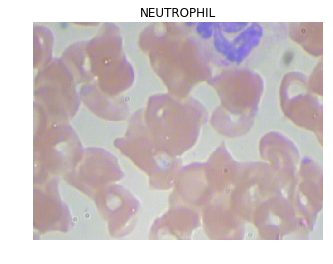

In [24]:
# Creating a ploting function to plot image along with its label
def plot_image(image_path):
    index = int(image_path.split("_")[-1].split(".")[0])  # extracting the image number from the path name
    title = labels.iloc[index]['Type']
    img = image.load_img(img_path)
    x = image.img_to_array(img)
    img = np.expand_dims(x, axis=0)
    plt.title(title)
    plt.axis('off')
    plt.imshow(np.vstack(img).astype(np.uint8))

# make sample calls
img_path = data_folder + "BloodImage_00002.jpg"
plot_image(img_path)


## Data Description: Blood types distribution

It's important to view the distribution of datapoints for the different classes, as we want to know if the is impalanced or not.

BASOPHIL        4
MONOCYTE       22
LYMPHOCYTE     37
EOSINOPHIL     94
NEUTROPHIL    216
dtype: int64


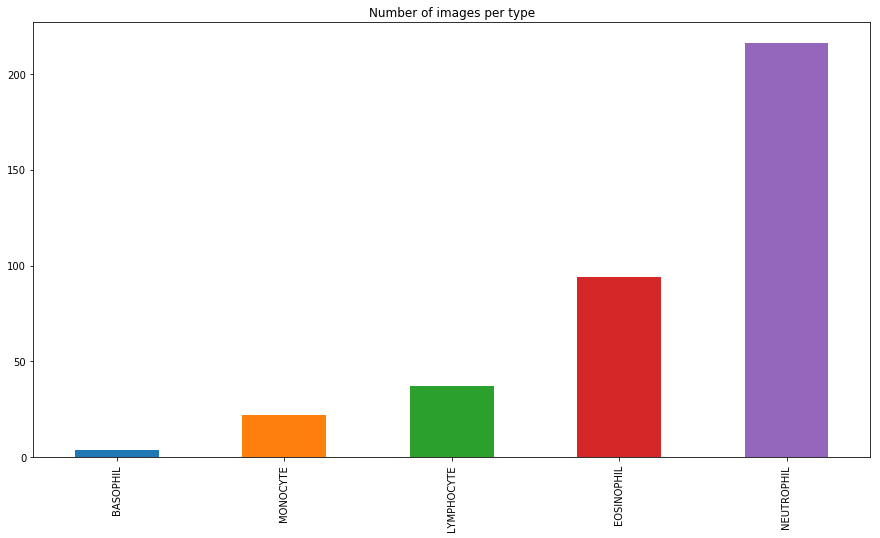

In [25]:
import string

blood_types = ['LYMPHOCYTE','MONOCYTE', 'BASOPHIL','EOSINOPHIL','NEUTROPHIL']
blood_types_count = [len(labels.loc[labels['Type'].str.find(blood_types[0]) != -1]),
               len(labels.loc[labels['Type'].str.find(blood_types[1]) != -1]),
               len(labels.loc[labels['Type'].str.find(blood_types[2]) != -1]),
               len(labels.loc[labels['Type'].str.find(blood_types[3]) != -1]),
               len(labels.loc[labels['Type'].str.find(blood_types[4]) != -1])]


# plot the distribution of blood types
blood_types_series = pd.Series(blood_types_count, index=blood_types).sort_values()
print(blood_types_series)
blood_types_series.plot.bar(title="Number of images per type", figsize=(15,8))


Here we can see that with the original images we have *imbalanced* class sizes.

## Execluding the 'BASOPHIL' class

In [26]:
# samples of 'BASOPHIL' class
labels.loc[labels['Type'].str.find('BASOPHIL') != -1]


,Id,Type
8,8,BASOPHIL
34,34,"NEUTROPHIL,BASOPHIL"
132,132,BASOPHIL
171,171,BASOPHIL


Since this class has only 4 samples, we will exclude it.

In [27]:
blood_types.remove('BASOPHIL')
print("\nNumber of records before filtering:", labels.shape[0])
labels = labels.loc[labels['Type'].str.find('BASOPHIL') == -1]
print("Number of records after filtering:", labels.shape[0])


Number of records before filtering: 365
Number of records after filtering: 361


## Execluding multilabeld samples  

we will not consider images with more than label since they're too few and making a dedicated class for them will imbalance the class sizes.

In [28]:
# multilabeld samples
labels.loc[labels['Type'].str.find(',') != -1]

,Id,Type
10,10,"NEUTROPHIL, EOSINOPHIL"
31,31,"NEUTROPHIL,NEUTROPHIL"
43,43,"NEUTROPHIL, MONOCYTE"
44,44,"EOSINOPHIL,EOSINOPHIL"
65,65,"NEUTROPHIL, NEUTROPHIL"
70,70,"EOSINOPHIL, LYMPHOCYTE"
103,103,"EOSINOPHIL, EOSINOPHIL"
176,176,"MONOCYTE, LYMPHOCYTE"
193,193,"NEUTROPHIL, EOSINOPHIL"
195,195,"LYMPHOCYTE, LYMPHOCYTE"


In [29]:
print("\nNumber of records before filtering:", labels.shape[0])
labels = labels.loc[labels['Type'].str.find(',') == -1]
print("Number of records after filtering:", labels.shape[0])


Number of records before filtering: 361
Number of records after filtering: 347


## Distribution After Preprocessing

{'LYMPHOCYTE': 33, 'MONOCYTE': 20, 'EOSINOPHIL': 88, 'NEUTROPHIL': 206}


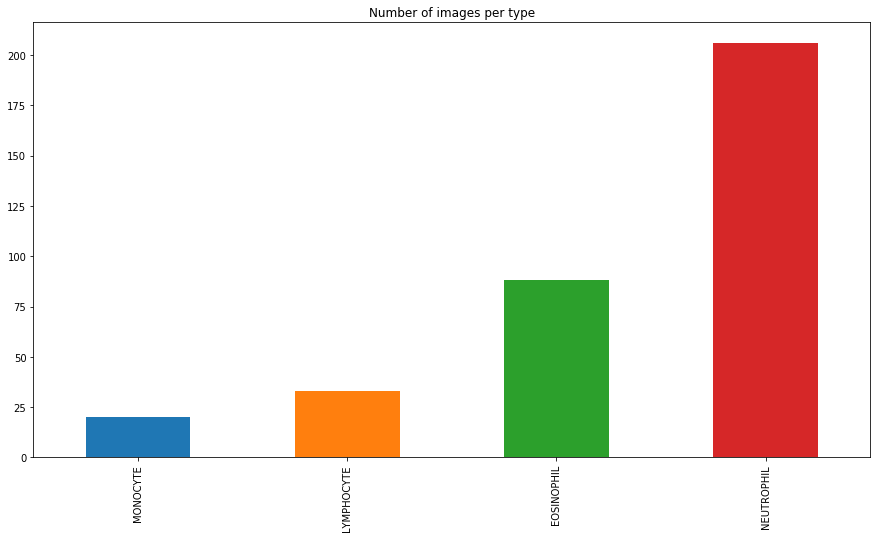

In [30]:
pd.value_counts(labels['Type'], ascending=True).plot.bar(title="Number of images per type", figsize=(15,8))

# create dictionary for number of class instances
types_count = {blood_types[0]: len(labels.loc[labels['Type'].str.find(blood_types[0]) != -1]),
               blood_types[1]: len(labels.loc[labels['Type'].str.find(blood_types[1]) != -1]),
               blood_types[2]: len(labels.loc[labels['Type'].str.find(blood_types[2]) != -1]),
               blood_types[3]: len(labels.loc[labels['Type'].str.find(blood_types[3]) != -1])
              }


print(types_count)


  
## Load image data


In [31]:
#
images = []
for id in labels['Id']:
    image_no = "0" * (5-len(str(id))) + str(id)
    image_name = "BloodImage_" + image_no + ".jpg"
     # loads RGB image as PIL.Image.Image type
    img_path = data_folder + image_name
    img = image.load_img(img_path, target_size=(244, 244))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    img = np.expand_dims(x, axis=0)
    images.append(img)
    
#
images = np.vstack(images)
images = images.astype(np.uint8)
images.shape


(347, 244, 244, 3)

## Visualize Sample Images

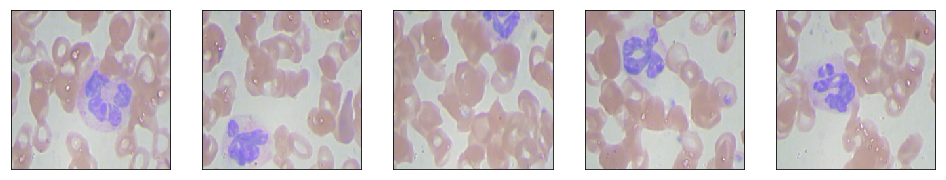

In [32]:
fig = plt.figure(figsize=(20,20))
for i in range(5):
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    ax.imshow(images[i])

  
## Splitting data


In [33]:
# Shuffle and split the data into training and testing subsets
target = labels.drop(['Id'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(images, target, test_size=0.20, random_state=7)

print("Total size of dataset:", len(images))
print("Size of training set:", len(X_train))
print("Size of testing set:", len(X_test))


Total size of dataset: 347
Size of training set: 277
Size of testing set: 70


## Saving Data

In [113]:
import scipy.misc


for i, img in enumerate(X_train):
    scipy.misc.toimage(img, cmin=0.0).save('../dataset/TRAINING/training_'+str(i)+'.jpg')

y_train.to_csv('../dataset/y_train.csv', index=False)

for i, img in enumerate(X_test):
    scipy.misc.toimage(img, cmin=0.0).save('../dataset/TEST/testing_'+str(i)+'.jpg')

y_test.to_csv('../dataset/y_test.csv', index=False)


c:\users\win8.1\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  """
c:\users\win8.1\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  # Remove the CWD from sys.path while we load stuff.


## Loading Saved Data

In [98]:
# load labels
y_train = pd.read_csv('../dataset/y_train.csv')
y_test = pd.read_csv('../dataset/y_test.csv')

# load training and testing images
def get_images(path, size, data_type):
    images = []
    for i in range(size):
        image_name = data_type + '_' + str(i) + ".jpg"
         # loads RGB image as PIL.Image.Image type
        img_path = path + image_name
        img = image.load_img(img_path)
        # convert PIL.Image.Image type to 3D tensor
        x = image.img_to_array(img)
        # convert 3D tensor to 4D tensor and return 4D tensor
        img = np.expand_dims(x, axis=0)
        images.append(img)
        #
    images = np.vstack(images)
    images = images.astype(np.uint8)
    return images

# load training set
X_train = get_images('../dataset/TRAINING/', y_train.shape[0], 'training')
# load testin set
X_test = get_images('../dataset/TEST/', y_test.shape[0], 'testing')

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)


Training set: (277, 244, 244, 3)
Testing set: (70, 244, 244, 3)


## Make validation set

In [99]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train,
                                                                y_train, test_size=0.20,
                                                                random_state=7)

print("training, validation (Pre-augmented) : (", len(X_train),",",len(X_validation),")")


training, validation (Pre-augmented) : ( 221 , 56 )


# Data augmentation

## Creating Data Generator

In [68]:
from keras.preprocessing import image

# create data generator
datagen_train = image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)


# create and configure augmented image generator
datagen_valid = image.ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(X_train, augment=True)
datagen_valid.fit(X_validation)


## Augmenting Types Classes

In [117]:
import os

labels = []
aug_count = {}
classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
for c in classes:
    #
    #print(c)
    class_y_train = y_train.loc[y_train['Type'] == c]
    class_x_train = []
    for i in class_y_train.index:
        class_x_train.append(X_train[i])
    class_x_train = np.array(class_x_train)
    #
    total_size_of_class = 3000 
    batch_size = 32
    batches = 0
    #
    for X_batch, y_batch in datagen_train.flow(X_train, y_train, batch_size=32,
                save_to_dir='..\\dataset\\aug_train\\'+c, save_prefix=c[:3], save_format='jpg'):
        batches += 1
        if batches >= (total_size_of_class-types_count[c])/batch_size:
            break
    size = len(os.listdir('..\\dataset\\aug_train\\'+c+'\\'))
    aug_count[c] = size
    print('Class "{}" has been augmented with {}'.format(c, size))




Class "LYMPHOCYTE" has been augmented with 2864
Class "MONOCYTE" has been augmented with 2896
Class "EOSINOPHIL" has been augmented with 2800
Class "NEUTROPHIL" has been augmented with 2717


## Distribution of Data After Augmentation

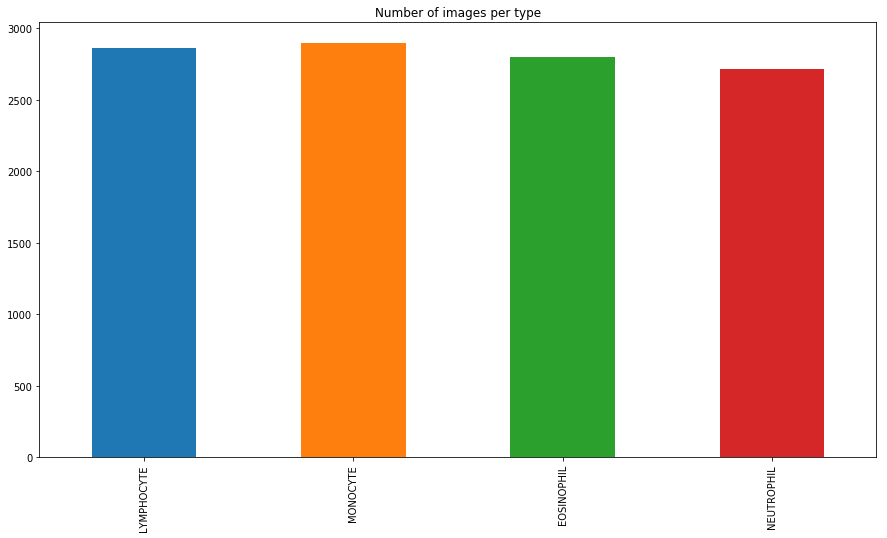

In [131]:
dist_series = pd.Series(aug_count)
dist_series.plot.bar(title="Number of images per type", figsize=(15,8))

## Loading Augmented Data

In [ ]:
import os

aug_x_train = []
aug_y_train = pd.DataFrame(columns=y_train.columns)
classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
for c in classes: 
    path = '..\\dataset\\aug_train\\'+ c +"\\"      
    for img_name in os.listdir(path):
         # loads RGB image as PIL.Image.Image type
        img_path = path + img_name
        img = image.load_img(img_path)
        # convert PIL.Image.Image type to 3D tensor
        x = image.img_to_array(img)
        # convert 3D tensor to 4D tensor and return 4D tensor
        img = np.expand_dims(x, axis=0)
        aug_x_train.append(img.astype(np.uint8))
        aug_y_train = aug_y_train.append(pd.Series({'Type': c}),ignore_index=True)

aug_x_train = np.vstack(aug_x_train)
aug_x_train = aug_x_train.astype(np.uint8)
print("Done !")


In [26]:
print("Augmented Training Data:", aug_x_train.shape)
print("Labels:", aug_y_train.shape)

Augmented Training Data: (11278, 244, 244, 3)
Labels: (11278, 4)


## Visualizing augmented data 

In [1]:
def plotImages( images_arr, n_images=4):
    fig, axes = plt.subplots(n_images, n_images, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()


# visualization of some images out of the preprocessing
plotImages(aug_x_train)


NameError: name 'aug_x_train' is not defined

## Rescale the Images

In [100]:
X_train = np.array(X_train)
X_train = X_train.astype('float32')/255.0

#aug_x_train = np.array(aug_x_train)
#aug_x_train = aug_x_train.astype('float32')/255.0

X_test = np.array(X_test)
X_test = X_test.astype('float32')/255.0


## Encode Categorical String Labels Using a One-Hot Scheme

In [101]:
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical

le = preprocessing.LabelEncoder()
le.fit(classes)
num_classes = len(classes)

def one_hot_encode(data):
    encoded_labels = data['Type'].apply(lambda x: le.transform([x])[0])
    encoded_labels = np.vstack(list(encoded_labels))
    hot_encoded = to_categorical(encoded_labels, num_classes=num_classes)
    return hot_encoded


y_train = one_hot_encode(y_train)
# aug_y_train = one_hot_encode(au_y_train)
y_test = one_hot_encode(y_test) 
y_validation = one_hot_encode(y_validation)



# Model Architecture (model 1: non-augmented)

In [102]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras import optimizers

# define parameters
batch_size = 32
epochs = 50
#
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
img_channel = X_train.shape[3]
input_shape = (img_rows, img_cols, img_channel)

# create the model and define the architecture.
non_aug_model = Sequential()
#
non_aug_model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same',
                         activation='relu', input_shape=input_shape))
non_aug_model.add(MaxPooling2D(pool_size=2))
non_aug_model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
non_aug_model.add(MaxPooling2D(pool_size=2))
non_aug_model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
non_aug_model.add(MaxPooling2D(pool_size=2))
non_aug_model.add(Dropout(0.5))
non_aug_model.add(Flatten())
non_aug_model.add(Dense(512, activation='relu'))
non_aug_model.add(Dropout(0.5))
# output layer
non_aug_model.add(Dense(num_classes, activation='softmax'))


print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'training samples')
non_aug_model.summary()


X_train shape: (221, 244, 244, 3)
221 training samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 244, 244, 64)      1792      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 122, 122, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 122, 122, 128)     32896     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 61, 61, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 61, 61, 256)       131328    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 30, 30, 256)       0         
_________________________________________________________________
dropout_9 (Dropout)  



# Model Architecture (model 2: augmented)

In [46]:
# create the model and define the architecture.
aug_model = Sequential()
#
aug_model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same',
                         activation='relu', input_shape=input_shape))
aug_model.add(MaxPooling2D(pool_size=2))
aug_model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
aug_model.add(MaxPooling2D(pool_size=2))
aug_model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
aug_model.add(MaxPooling2D(pool_size=2))
aug_model.add(Dropout(0.5))
aug_model.add(Flatten())
aug_model.add(Dense(512, activation='relu'))
aug_model.add(Dropout(0.5))
# output layer
aug_model.add(Dense(num_classes, activation='softmax'))


print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'training samples')
aug_model.summary()


X_train shape: (221, 244, 244, 3)
221 training samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 244, 244, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 122, 122, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 122, 122, 128)     32896     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 61, 61, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 256)       131328    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
dropout_3 (Dropout)  

## Compile Models

In [103]:
import keras

#compile
non_aug_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#aug_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


## Calculate the Classification Accuracy on the Test Set (Before Training)

In [50]:
# evaluate test accuracy
score_non_aug = non_aug_model.evaluate(X_test, y_test, verbose=0)
score_aug = aug_model.evaluate(X_test, y_test, verbose=0)

accuracy_non_aug = 100*score_non_aug[1]
accuracy_aug = 100*score_aug[1]
# print test accuracy
print('Test accuracy (non-augmented): %.4f%%' % accuracy_non_aug)
print('Test accuracy (augmented): %.4f%%' % accuracy_aug)

Test accuracy (non-augmented): 31.4286%
Test accuracy (augmented): 5.7143%


## Train Model 1

In [107]:
from keras.callbacks import ModelCheckpoint   


# train the model
checkpointer_1 = ModelCheckpoint(filepath='non_aug.model.best.hdf5', 
                               verbose=1, save_best_only=True)

history_non_aug = non_aug_model.fit(X_train,
                                    y_train,
                                    epochs=epochs,
                                    validation_data= (X_validation, y_validation),
                                    callbacks=[checkpointer_1],
                                    verbose = 1,
                                    shuffle=True)


Train on 221 samples, validate on 56 samples
Epoch 1/50


ResourceExhaustedError: OOM when allocating tensor with shape[230400,512] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[Node: training/RMSprop/mul_18 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](RMSprop_2/rho/read, training/RMSprop/Variable_6/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


## Load the Model with the Best Classification Accuracy on the Validation Set

In [0]:
# load the weights that yielded the best validation accuracy
non_aug_model.load_weights('non_aug.model.best.hdf5')


## Calculate the Classification Accuracy on the Test Set (model 1)


In [32]:
# evaluate test accuracy
score = non_aug_model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)


Test accuracy: 54.2857%


## Confusion Matrix (model 1)

In [1]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = non_aug_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true = np.argmax(np.array(y_test), axis=1)
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = y_test.columns) 
plt.show()


NameError: name 'plt' is not defined

## Train Model 2

In [34]:
# train the model
checkpointer_2 = ModelCheckpoint(filepath='aug.model.best.hdf5', 
                               verbose=1, save_best_only=True)

history_aug = aug_model.fit_generator(
        datagen_train.flow(X_train, y_train, batch_size=batch_size),
        steps_per_epoch=len(X_train)/batch_size,
        epochs=epochs,
        validation_data=[X_validation, y_validation],
        validation_steps=len(X_validation)/batch_size,
        callbacks=[checkpointer_2],
        verbose = 1,
        class_weight=class_weight_dic)


Epoch 1/50
7/6 [==============================] - 6s 915ms/step - loss: 32.5030 - acc: 0.4771 - val_loss: 3.2236 - val_acc: 0.8000

Epoch 00001: val_loss improved from inf to 3.22362, saving model to aug.model.best.hdf5
Epoch 2/50
7/6 [==============================] - 4s 607ms/step - loss: 38.5946 - acc: 0.5623 - val_loss: 3.2236 - val_acc: 0.8000

Epoch 00002: val_loss did not improve from 3.22362
Epoch 3/50
7/6 [==============================] - 4s 613ms/step - loss: 38.5468 - acc: 0.5631 - val_loss: 3.2236 - val_acc: 0.8000

Epoch 00003: val_loss did not improve from 3.22362
Epoch 4/50
7/6 [==============================] - 5s 653ms/step - loss: 38.5475 - acc: 0.5628 - val_loss: 3.2236 - val_acc: 0.8000

Epoch 00004: val_loss did not improve from 3.22362
Epoch 5/50
7/6 [==============================] - 4s 576ms/step - loss: 38.6085 - acc: 0.5623 - val_loss: 3.2236 - val_acc: 0.8000

Epoch 00005: val_loss did not improve from 3.22362
Epoch 6/50
7/6 [==============================] 

## Load the Model with the Best Classification Accuracy on the Validation Set

In [0]:
# load the weights that yielded the best validation accuracy
aug_model.load_weights('aug.model.best.hdf5')


## Calculate the Classification Accuracy on the Test Set (model 2)


In [36]:
# evaluate test accuracy
score = aug_model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)


Test accuracy: 54.2857%


## Confusion Matrix (model 2)

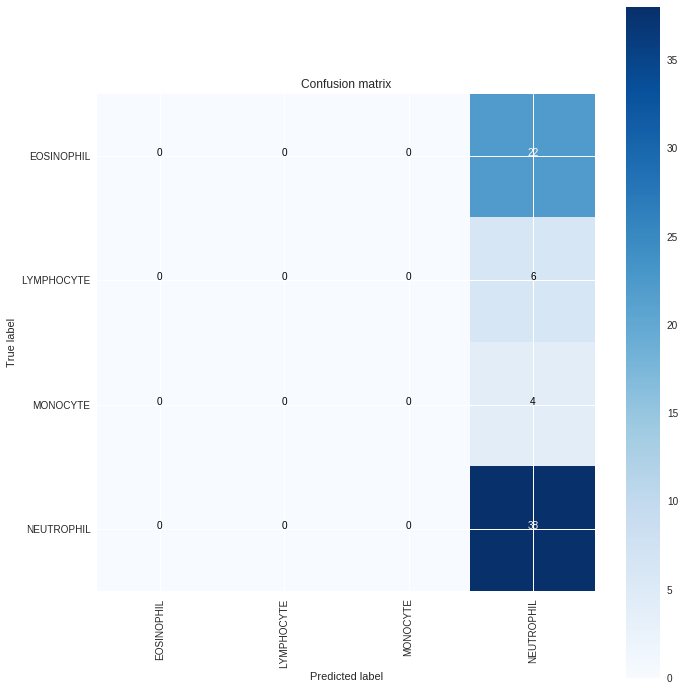

In [39]:
#
y_pred = aug_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true = np.argmax(np.array(y_test), axis=1)
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = y_test.columns) 
plt.show()


## Classification Report

In [40]:
print(classification_report(y_true, y_pred_classes, target_names=y_test.columns))

             precision    recall  f1-score   support

 EOSINOPHIL       0.00      0.00      0.00        22
 LYMPHOCYTE       0.00      0.00      0.00         6
   MONOCYTE       0.00      0.00      0.00         4
 NEUTROPHIL       0.54      1.00      0.70        38

avg / total       0.29      0.54      0.38        70



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Model Performance Summary

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


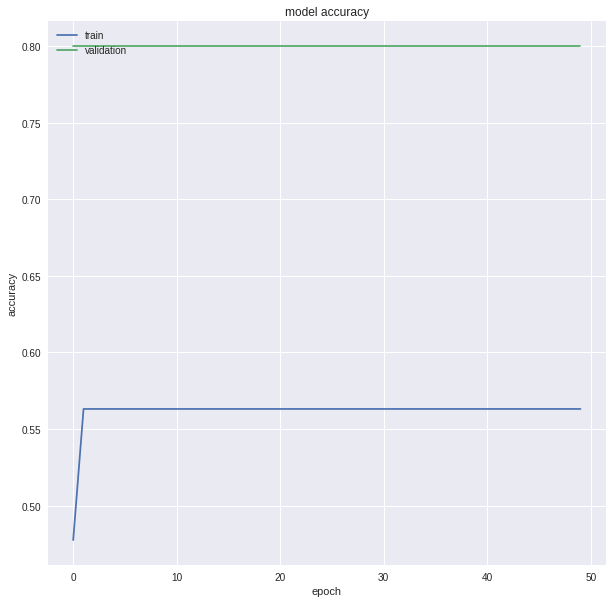

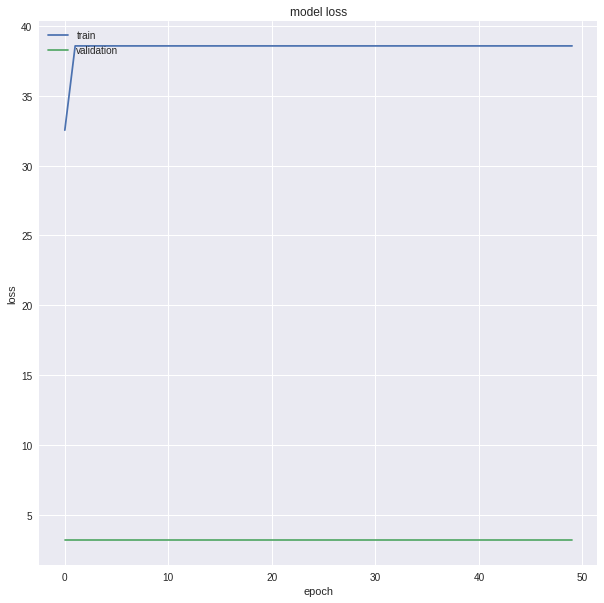

In [41]:
# list all data in history
print(history_aug.history.keys())
# summarize history for accuracy
plt.figure(figsize = (10,10))
plt.plot(history_aug.history['acc'])
plt.plot(history_aug.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize = (10,10))
plt.plot(history_aug.history['loss'])
plt.plot(history_aug.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Transfer Learning: convNet


![method](images/method.png)


The approach:
- slice off most of the pre-trained layers near the beginning of the network
- add to the remaining pre-trained layers a new fully connected layer that matches the number of classes in the new data set
- randomize the weights of the new fully connected layer; freeze all the weights from the pre-trained network
- train the network to update the weights of the new fully connected layer  


![approach](images/approach.png)


## The VGG-16 model

In [42]:
from keras.applications.vgg16 import VGG16, preprocess_input

# VGG16 model
model_VGG16 = VGG16(include_top=False, input_shape =(244, 244, 3))
#
print("Layers:", len(model_VGG16.layers))
model_VGG16.summary()


Layers: 19
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0         

## Calculate the image input

In [0]:
# calculate the image input
img_input = preprocess_input(images.astype('float64'))

In [178]:
#
predections = model_VGG16.predict(img_input)
predections.shape


(347, 7, 7, 512)

## Define a Model Architecture

In [43]:
#
top_model = Sequential()
# input shape is the shape of last VGG16 pooling layer
top_model.add(Flatten(input_shape=model_VGG16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
# output layer
top_model.add(Dense(num_classes, activation='softmax'))
#
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 1028      
Total params: 6,423,812
Trainable params: 6,423,812
Non-trainable params: 0
_________________________________________________________________


In [44]:
# set the first 19 layers to non-trainable (weights will not be updated)
for layer in model_VGG16.layers:
    layer.trainable = False


# add the model on top of the convolutional base
new_model = Sequential()
for layer in model_VGG16.layers:
  new_model.add(layer)
  
for layer in top_model.layers:
  new_model.add(layer)

#  
print ("Model Layers: ", len(new_model.layers))

new_model.summary()

Model Layers:  23


## Compile Model

In [0]:
# compile model
new_model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

## Training the model

In [0]:
# train the model
checkpointer_VGG16 = ModelCheckpoint(filepath='VGG16.model.best.hdf5', 
                               verbose=1, save_best_only=True)

history_VGG16  = new_model.fit_generator(
        datagen_train.flow(X_train, y_train, batch_size=batch_size),
        steps_per_epoch=len(X_train)/batch_size,
        epochs=epochs,
        validation_data=[X_validation, y_validation],
        validation_steps=len(X_validation)/batch_size,
        callbacks=[checkpointer_VGG16],
        verbose = 1,
        class_weight=class_weight_dic)

Epoch 1/50
7/6 [==============================] - 13s 2s/step - loss: 5.8076 - acc: 0.3107 - val_loss: 1.3117 - val_acc: 0.0727

Epoch 00001: val_loss improved from inf to 1.31169, saving model to VGG16.model.best.hdf5
Epoch 2/50
7/6 [==============================] - 3s 450ms/step - loss: 5.4021 - acc: 0.3023 - val_loss: 1.0600 - val_acc: 0.7818

Epoch 00002: val_loss improved from 1.31169 to 1.05999, saving model to VGG16.model.best.hdf5
Epoch 3/50
7/6 [==============================] - 4s 622ms/step - loss: 5.2016 - acc: 0.3283 - val_loss: 1.3886 - val_acc: 0.2909

Epoch 00003: val_loss did not improve from 1.05999
Epoch 4/50
7/6 [==============================] - 4s 612ms/step - loss: 4.9046 - acc: 0.3544 - val_loss: 1.2130 - val_acc: 0.6545

Epoch 00004: val_loss did not improve from 1.05999
Epoch 5/50
7/6 [==============================] - 4s 617ms/step - loss: 4.9101 - acc: 0.3457 - val_loss: 1.2556 - val_acc: 0.4000

Epoch 00005: val_loss did not improve from 1.05999
Epoch 6/50

## Load the Model with the Best Classification Accuracy on the Validation Set

In [0]:
# load the weights that yielded the best validation accuracy
new_model.load_weights('VGG16.model.best.hdf5')


## Calculate the Classification Accuracy on the Test Set (VGG16 )


In [0]:
# evaluate test accuracy
score = new_model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)


## Confusion Matrix (VGG16 )

In [0]:
#
y_pred = new_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true = np.argmax(np.array(y_test), axis=1)
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = y_test.columns) 
plt.show()


## Classification Report

In [0]:
print(classification_report(y_true, y_pred_classes, target_names=y_test.columns))

# Conclusion

....

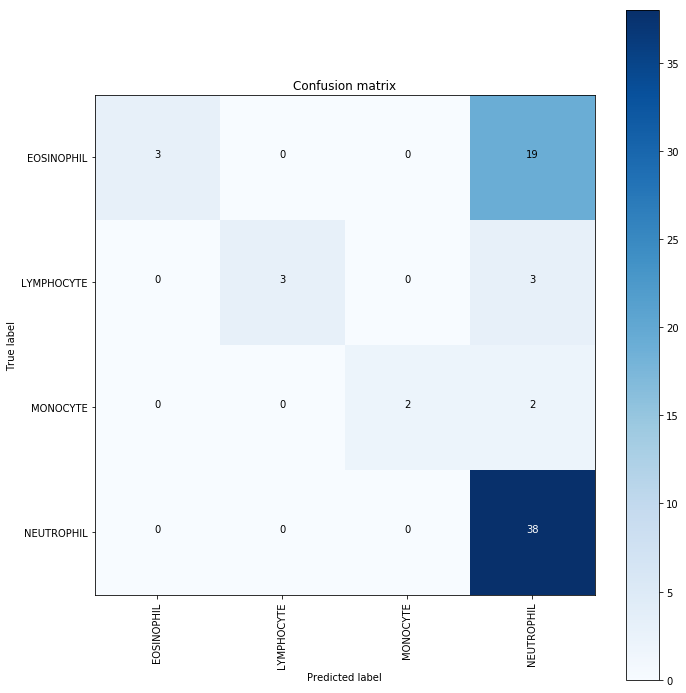

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# 70 test = 38 n (3) + 4 m (2) + 6 l(1) + 22 e(0)
classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
y_pred_classes = [3]*38 + [2]*2 + [3]*2+ [1]*3 + [3]*3 + [0]*3 + [3]* 19
y_true = [3]*38 + [2]*4 + [1]*6 + [0]*22

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = classes) 
plt.show()
